# **1. Imports, installations and settings**

In [2]:
# import os
# os.chdir("/home/yaroslav/FCUL/MARS_1.0")

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/lisboa_ciencia_de_dados/MARS_1.0')
!pip install -qq igraph ijson

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 13.4 MB/s eta 0:00:00


In [3]:
import gc
import pickle
import igraph as ig
import pandas as pd
from time import perf_counter
import traceback
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from project_cda.tag_formatter import set_log_level, log

In [4]:
set_log_level('DEBUG')  # verbose but useful setting
# set_log_level('INFO')
# set_log_level('WARNING')
# set_log_level('ERROR')

In [5]:
from project_cda.anime_graph_builder import AnimeGraphBuilder
from project_cda.community_tracker import CommunityTracker
from project_cda.cluster_evaluation import ClusterEvaluation
from project_cda.partition_enricher import PartitionEnricher
from project_cda.cluster_visualizer import ClusterVisualizer
from project_cda.path_manager import PathManager

In [6]:
DATA_DIR = "data"
USERS_CSV_PATH = f"{DATA_DIR}/datasets/anime_azathoth42/users_sterilized.csv" # cleaned files which were cleaned more carefully
USER_DICT_PATH = f"{DATA_DIR}/helpers/user_dict_filtered.json"   # 95 percentile
ANIME_CSV_PATH = f"{DATA_DIR}/datasets/anime_azathoth42/anime_sterilized.csv"

In [7]:
graph_builder = AnimeGraphBuilder(users_csv_path=USERS_CSV_PATH,
                                 user_dict_json_path=USER_DICT_PATH,
                                 anime_csv_path=ANIME_CSV_PATH)

[10:53:30] [DEBUG] [AGB] Anime Graph Builder initialzed for


# **2. EDGING SETTINGS (keep **ONE** option uncommented)**

In [9]:
# === EDGES SETTINGS ===
def get_edges_config():
    # --- METHOD: Jaccard + KNN ---
    return {
        "name": "jaccard",
        "kwargs": {"threshold": 0.05}
    }

    # --- METHOD: Raw / Projected ---
    # return {
    #     "name": "raw",
    #     "kwargs": {"threshold": 0},
    # }

# **3. SPARSING SETTINGS (keep **ONE** option uncommented)**

In [10]:

def get_sparsing_config():
    # --- METHOD: No sparsing ---
    return {"name": "full",
            "kwargs": {}}

    # --- METHOD: KNN ---
    # return {
    #     "name": "knn",
    #     "kwargs": {"k": 10},
    # }

    # --- METHOD: Backbone ---
    # return {
    #     "name": "backbone",
    #     "kwargs": {"alpha": 0.05}
    # }

# **3. CLUSTERING ALGORITHM SETTINGS (keep **ONE** option uncommented)**

In [11]:
# === НАСТРОЙКИ АЛГОРИТМА ===
def get_algo_config():
    # --- 1. LEIDEN: MODULARITY (Классика) ---
    return {
        "name": "leiden_mod",
        "kwargs": {
            "objective_function": "modularity",
            "resolution": 1.5,
            "n_iterations": -1
        }
    }

    # --- 2. LEIDEN: CPM (Constant Potts Model) ---
    # return {
    #     "name": "leiden_cpm",
    #     "kwargs": {
    #         "objective_function": "CPM",
    #         "resolution": 0.05, # 0.01, 0.05, 0.1...
    #         "n_iterations": -1
    #     }
    # }

    # --- 3. LEADING EIGENVECTOR ---
    # return {
    #     "name": "eigenvector",
    #     "kwargs": {
    #         "clusters": None
    #     }
    # }

    # --- 4. WALKTRAP (Random Walks) ---
    # return {
    #     "name": "walktrap",
    #     "kwargs": {
    #         "steps": 4
    #     }
    # }

    # --- 5. INFOMAP (Flow-based) ---
    # return {
    #     "name": "infomap",
    #     "kwargs": {
    #         "trials": 25
    #     }
    # }

    # --- 6. LABEL PROPAGATION ---
    # return {
    #     "name": "label_propagation",
    #     "kwargs": {}
    # }

# **4. Absorbe all the configs and pull the settings of cluterization**

In [12]:
base_path = ""
pm = PathManager(base_path)
EDGES_CONF = get_edges_config()
SPARS_CONF = get_sparsing_config()
ALGO_CONF = get_algo_config()
GRAPH_TYPE = 'anime' # or 'users'
paths = pm.get_paths(GRAPH_TYPE, EDGES_CONF, SPARS_CONF, ALGO_CONF)
pm.ensure_dirs(paths)
paths

{'graph_type': 'anime',
 'raw_dir': 'data/graphs/anime/raw/jacth005',
 'input_graph_dir': 'data/graphs/anime/sparse/jacth005_full',
 'experiment_dir': 'data/experiments/anime/jacth005_full_ldnMODiter-1res15',
 'exp_id': 'jacth005_full_ldnMODiter-1res15'}

# **5. Some auxiliary functions**

In [14]:
def get_or_build_raw(year, raw_dir, build_cfg, builder):
    """
    Guarantees the returning of raw graph.
    1. Looking for it in the cache (raw_dir).
    2. If not found — builds from scratch and save into the cache.
    """
    filename = f"{year}.pkl"
    raw_path = os.path.join(raw_dir, filename)

    # 1. Try to load from cache
    if os.path.exists(raw_path):
        log(f"Loading RAW graph from: {raw_path}", tag="CACHE", level='DEBUG')
        try:
            with open(raw_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            log(f"Corrupt RAW cache {year}: {e}. Rebuilding...", tag="WARN", level='WARNING')

    # 2. Building from scratch
    log(f"Building RAW graph from scratch for {year}...", tag="BUILD", level='DEBUG')
    t = perf_counter()

    # Building edges
    edges, counts = builder.build_edges(year=year, **build_cfg['kwargs'])

    # Building graph. Saving into the cache
    G_raw = builder.build_graph(edges, counts, output_path=raw_path)

    log(f"Raw built in {perf_counter() - t:.2f}s", tag="TIME", level='DEBUG')

    # Memory cleaning
    del edges, counts
    gc.collect()

    return G_raw

def get_target_graph(year, paths, build_cfg, sparse_cfg, builder):
    """
    Returning the final graph, ready for clusterization (sparsed or raw).
    1. Checks for existence of target file.
    2. If nt found — gets the graph through the function above and sparse it.
    """
    filename = f"{year}.pkl"
    target_path = os.path.join(paths['input_graph_dir'], filename)

    # 1. If the target file exists - just load
    if os.path.exists(target_path):
        log(f"Target graph found: {target_path}", tag="CACHE", level='DEBUG')
        try:
            with open(target_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            log(f"Corrupt Target cache: {e}. Will regenerate.", tag="WARN", level='WARNING')

    # 2. If the target graph doesn't exist — we need the raw or sparsed "source"
    # This function decides - load or build
    G = get_or_build_raw(year, paths['raw_dir'], build_cfg, builder)

    # 3. If sparsing needed - sparse it
    if sparse_cfg:
        log(f"Sparsifying ({sparse_cfg['name']})...", tag="SPARSE", level='DEBUG')

        # takes parameters of sparsing
        s_kwargs = sparse_cfg['kwargs'].copy()
        s_kwargs['output_path'] = target_path # because builder put here

        method = sparse_cfg['name']
        if method == 'knn':
            G = builder.sparsify_knn(G, **s_kwargs)
        elif method == 'backbone':
            G = builder.sparsify_backbone(G, **s_kwargs)
        # else:
        #     raise ValueError(f"Unknown sparse method: {method}")  # we can use flag "full" for absence of sparsing
    else:
        # 4. If sparsing doesn't needed -> the raw graph is our exact target.
        pass

    return G

# **6. Main loop through years.**

### Through the execution we don't only calculate but also save the results step by step. Because in this case later we could calculate another clusterization on the same raw/sparse graph settings much-much faster

In [ ]:
partitions_by_year = {}
modularity_by_year = {}

raw_dir = paths['raw_dir']          # for raw graphs (for example .../raw/jac005 for jaccard threshold 0.05)
input_dir = paths['input_graph_dir'] # folder from which we take the graph for clusterization (can be ...raw/... or ...sparse/...)

log(f"Graph Source: {input_dir}", tag="SETUP", level='INFO')
if paths['experiment_dir']:
    log(f"Experiment Output: {paths['experiment_dir']}", tag="SETUP", level='INFO')

for year in range(2006, 2019):
    log(f">>> Processing {year}...", tag="YEAR", level='INFO')

    try:
        G = get_target_graph(year, paths, EDGES_CONF, SPARS_CONF, graph_builder)

        log(f"Clustering with {ALGO_CONF['name']}...", tag="ALGO", level='DEBUG')

        if "weight" in G.edge_attributes():
            weights = G.es["weight"]
        else:
            weights = None
            log("No weights found in graph, clustering will be unweighted.", tag="WARN", level='WARNING')

        algo_name = ALGO_CONF['name'] # get the settings for sparsing
        algo_args = ALGO_CONF.get('kwargs', {})
        log(f"Clustering: {algo_name}", tag="ALGO", level='DEBUG')
        t_c = perf_counter()

        if algo_name in ['leiden_mod', 'leiden_cpm']:
            partition = G.community_leiden(weights=weights, **algo_args)
        elif algo_name == 'eigenvector':
            partition = G.community_leading_eigenvector(weights=weights, **algo_args)
        elif algo_name == 'walktrap':
            wc = G.community_walktrap(weights=weights, **algo_args)
            partition = wc.as_clustering()
        elif algo_name == 'infomap':
            partition = G.community_infomap(edge_weights=weights, **algo_args)
        elif algo_name == 'label_propagation':
            partition = G.community_label_propagation(weights=weights) # kwargs пустые обычно
        else:
            raise ValueError(f"Unknown algo: {algo_name}")

        log(f"Clustered in {perf_counter() - t_c:.2f}s", tag="TIME", level='DEBUG')

        real_names = G.vs['name']
        membership = partition.membership
        partitions_by_year[year] = dict(zip(real_names, membership))  # later we will track the clusters through years and align them

        try:
            mod_val = G.modularity(membership, weights=weights)
        except Exception:
            mod_val = 0.0

        modularity_by_year[year] = mod_val  # also useful metrics

        log(f"Done. Stats -> Modularity: {mod_val:.4f}, Clusters: {len(set(membership))}", tag="RESULT", level='INFO')

        del partition, weights, G # memory cleaning
        gc.collect()

    except Exception as e:
        log(f"Clustering Error in {year}: {e}", tag="ERROR", level='ERROR')
        traceback.print_exc()


[04:44:25] [INFO] [SETUP] Graph Source: data/graphs/anime/sparse/jacth005_full
[04:44:25] [INFO] [SETUP] Experiment Output: data/experiments/anime/jacth005_full_ldnMODiter-1res15
[04:44:25] [INFO] [YEAR] >>> Processing 2006...
[04:44:25] [DEBUG] [CACHE] Loading RAW graph from: data/graphs/anime/raw/jacth005/2006.pkl
[04:44:27] [DEBUG] [SPARSE] Sparsifying (full)...
[04:44:27] [DEBUG] [ALGO] Clustering with leiden_mod...
[04:44:27] [DEBUG] [ALGO] Clustering: leiden_mod
[04:44:27] [DEBUG] [TIME] Clustered in 0.03s
[04:44:27] [INFO] [RESULT] Done. Stats -> Modularity: 0.3365, Clusters: 15
[04:44:27] [INFO] [YEAR] >>> Processing 2007...
[04:44:27] [DEBUG] [CACHE] Loading RAW graph from: data/graphs/anime/raw/jacth005/2007.pkl
[04:44:28] [DEBUG] [SPARSE] Sparsifying (full)...
[04:44:28] [DEBUG] [ALGO] Clustering with leiden_mod...
[04:44:28] [DEBUG] [ALGO] Clustering: leiden_mod
[04:44:28] [DEBUG] [TIME] Clustered in 0.28s
[04:44:29] [INFO] [RESULT] Done. Stats -> Modularity: 0.2982, Cluste

# **7. Community tracking**

### Each cluster won't have the same label in different year partitions. We need to align them ourselves. To do it we use Jaccard coefficient of similarity (0.1 by default). If two clusters in the year **T+1** are looks like some cluster from **T** (two boys are trying to call him "father"), then those will get "father's" label, who is more similar. The second one will establish his own new cluster.

In [ ]:
base_partition_filename = f"partition.csv"
base_partition_path = os.path.join(paths['experiment_dir'], base_partition_filename)

tracker = CommunityTracker(threshold=0.1)
aligned_partitions = tracker.track_communities(partitions_by_year)
CommunityTracker.save_aligned_history_to_csv(aligned_partitions, base_partition_path)

[04:44:51] [INFO] [TRACK] Year 2006: done. Unique clusters: 15
[04:44:51] [INFO] [TRACK] Year 2007: done. Unique clusters: 17
[04:44:51] [INFO] [TRACK] Year 2008: done. Unique clusters: 21
[04:44:51] [INFO] [TRACK] Year 2009: done. Unique clusters: 33
[04:44:51] [INFO] [TRACK] Year 2010: done. Unique clusters: 34
[04:44:51] [INFO] [TRACK] Year 2011: done. Unique clusters: 35
[04:44:51] [INFO] [TRACK] Year 2012: done. Unique clusters: 49
[04:44:51] [INFO] [TRACK] Year 2013: done. Unique clusters: 46
[04:44:51] [INFO] [TRACK] Year 2014: done. Unique clusters: 47
[04:44:51] [INFO] [TRACK] Year 2015: done. Unique clusters: 49
[04:44:52] [INFO] [TRACK] Year 2016: done. Unique clusters: 47
[04:44:52] [INFO] [TRACK] Year 2017: done. Unique clusters: 48
[04:44:52] [INFO] [TRACK] Year 2018: done. Unique clusters: 44
[04:44:52] [INFO] [TRACK] Saved partition detail to data/experiments/anime/jacth005_full_ldnMODiter-1res15/partition.csv
[04:44:52] [INFO] [TRACK] Saved partition stats to  data/exp

# **8. Enrichment**

### All the way above we knew only the main features of the nodes: their ID ('anime_id': int for anime titles or 'username': str for users). But further we need to enrich their set of features with the original dataset. This features will be used for analysis of some useful metrics and later - for ML prediction of migrations.

In [ ]:
enricher = PartitionEnricher(metadata_path=ANIME_CSV_PATH, key_col="anime_id", set_cols=["genres", "studio"])
anime_meta_dict = enricher.get_metadata_dict()

partition_enriched = enricher.enrich_partition(f"{paths['experiment_dir']}/{base_partition_filename}")

In [ ]:
print(partition_enriched.head())

   year  anime_id  cluster_id  Unnamed: 0  \
0  2006         1           0           0   
1  2006         5           0           1   
2  2006         6           0           2   
3  2006         7           0           3   
4  2006         8           1           4   

                                           image_url  score  scored_by  \
0  https://myanimelist.cdn-dena.com/images/anime/...   8.81     365465   
1  https://myanimelist.cdn-dena.com/images/anime/...   8.41     111344   
2  https://myanimelist.cdn-dena.com/images/anime/...   8.31     197843   
3  https://myanimelist.cdn-dena.com/images/anime/...   7.34      31908   
4  https://myanimelist.cdn-dena.com/images/anime/...   7.04       4760   

     rank                                      opening_theme  \
0    27.0            ['"Tank!" by The Seatbelts (eps 1-25)']   
1   157.0  ['"Ask DNA" by The Seatbelts featuring Raju Ra...   
2   234.0                       ['"H.T." by Tsuneo Imahori']   
3  2292.0                   

# **9. Evaluation**

### For evaluaion the cluterization we calculate the *year-by-year evolution* of such metrics:

- **Gini:** we have a giant cluster of "mainstream" anime? Or a lot of subcultures?

- **Entropy:** is the community landscape is rich and diverse? Or monotonous and predictable?

- **AMI stability:** how much information is shared between the clustering of the previous year and the current year? How big is volatility? Do they travel often from cluster to cluster?

- **Source purity:** how the hypothesis "the clusterization is driven only by relation to source" is probable?

- **Genre purity:** is the classical dividing by genres find it's reflection in clusterization? How the hiphotesis "person always choose anime of one exact genre" is probable?

- **Modularity:** how the clusterization is meaningful? How far it is from random cluserization? After all - how reliable are our results?

- **Number of clusters:** do people prefer form big groups by interests or small?

### Every value above is not only important by itself but need to be discussed in aggregation with others.

In [ ]:
evaluator = ClusterEvaluation(paths['exp_id'], aligned_partitions, anime_info=anime_meta_dict,modularity_dict=modularity_by_year)
evaluation_df = evaluator.get_trajectory_df()

base_evaluation_filename = f"evaluation.csv"
base_evaluation_path = os.path.join(paths['experiment_dir'], base_evaluation_filename)
evaluation_df.to_csv(base_evaluation_path, index=False, encoding='utf-8')
evaluation_df

[04:44:53] [INFO] [EVAL] Calculating trajectory for jacth005_full_ldnMODiter-1res15...


,Method,Gini_Spatial,Entropy_Info,Stability_AMI,Purity_Source,Purity_Genre,Modularity,N_Clusters
Year,,,,,,,,
2006,jacth005_full_ldnMODiter-1res15,0.283242,2.549937,NaN,0.525308,0.604651,0.336461,15
2007,jacth005_full_ldnMODiter-1res15,0.680201,1.934940,0.133055,0.484384,0.550685,0.298165,17
2008,jacth005_full_ldnMODiter-1res15,0.610039,2.361928,0.531571,0.502407,0.597812,0.286814,21
2009,jacth005_full_ldnMODiter-1res15,0.787281,2.221067,0.703308,0.513017,0.561639,0.263017,33
2010,jacth005_full_ldnMODiter-1res15,0.757831,2.383884,0.702722,0.482970,0.579019,0.253480,34
2011,jacth005_full_ldnMODiter-1res15,0.762748,2.391483,0.751370,0.487583,0.582071,0.280206,35
2012,jacth005_full_ldnMODiter-1res15,0.807186,2.516235,0.805465,0.482285,0.577589,0.288687,49
2013,jacth005_full_ldnMODiter-1res15,0.788299,2.555596,0.807487,0.483392,0.582285,0.291800,46
2014,jacth005_full_ldnMODiter-1res15,0.785354,2.590104,0.734975,0.460870,0.578490,0.289609,47


# **10. Plots**

### Plotly interactive plots is so suitable for visualization of the system evolution, migration flows (especially **sankey** diagram).

In [ ]:
viz = ClusterVisualizer(partition_enriched)

# A. Sankey
viz.plot_sankey(
    filename=os.path.join(paths['experiment_dir'], "sankey.html"),
    key_col="anime_id",
    name_col="title",
    feature_cols=["genres", "studio"],
    metric_col="score",
    sort_col="members",
    age_col="year_start",
    min_link_size=5,
    title="Anime Clusters Over Time"
    )

# B. Streamgraph
viz.plot_streamgraph(
    filename=os.path.join(paths['experiment_dir'], "stream.html"),
    feature_col="genres",
    title="Rise and Fall of Anime Genres"
)

# C. Bubbles (Optional)
viz.plot_bubbles(
    filename=os.path.join(paths['experiment_dir'], "bubbles.html"),
    x_col="score",      # Чем правее, тем выше оценка
    y_col="members",    # Чем выше, тем популярнее
    size_col="count",   # Размер = кол-во тайтлов
    title="Anime Landscape: Quality vs Popularity"
)

# D. Солнце (Иерархия)
viz.plot_sunburst(
    filename=os.path.join(paths['experiment_dir'], "sunburst.html"),
    feature_col="genres", # Год -> Кластер -> Студия
    title="Anime Source Hierarchy"
)

[04:44:54] [DEBUG] [PLOT] Generating Sankey diagram (Anime Clusters Over Time)...
[04:44:56] [INFO] [PLOT] Plot saved to data/experiments/anime/jacth005_full_ldnMODiter-1res15/sankey.html
[04:44:56] [DEBUG] [PLOT] Generating Streamgraph (Rise and Fall of Anime Genres)...
[04:44:59] [INFO] [PLOT] Plot saved to data/experiments/anime/jacth005_full_ldnMODiter-1res15/stream.html
[04:44:59] [DEBUG] [PLOT] Generating Bubble Chart (Anime Landscape: Quality vs Popularity)...
[04:45:00] [INFO] [PLOT] Plot saved to data/experiments/anime/jacth005_full_ldnMODiter-1res15/bubbles.html
[04:45:00] [DEBUG] [PLOT] Generating Sunburst (Anime Source Hierarchy)...
[04:45:03] [INFO] [PLOT] Plot saved to data/experiments/anime/jacth005_full_ldnMODiter-1res15/sunburst.html


# **11. Appendix**

### We can try to estimate the behavior of Leiden-modularity clusterization depending of the resolution parameter. Use the lightweight analog of the big cycle above.

If want to relaunch, din't forget previously relaunch cells from the paragraphs 1-5.

In [18]:
set_log_level('INFO')

res_buffer = []
for resolution in range(1, 51):
  res = resolution / 10   # we will obtain the evolution of modularity for each value of resolution
  print(f"==================== RES: {res} ====================")

  raw_dir = paths['raw_dir']          # for raw graphs (for example .../raw/jac005 for jaccard threshold 0.05)
  input_dir = paths['input_graph_dir'] # folder from which we take the graph for clusterization (can be ...raw/... or ...sparse/...)

  for year in range(2006, 2019):
      log(f">>> Processing {year}...", tag="YEAR", level='INFO')

      try:
          G = get_target_graph(year, paths, EDGES_CONF, SPARS_CONF, graph_builder)

          if "weight" in G.edge_attributes():
              weights = G.es["weight"]

          partition = G.community_leiden(objective_function='modularity', resolution=res)
          # partition = G.community_leiden(objective_function='CPM', )
          # partition = G.community_leading_eigenvector(weights=weights)
          # wc = G.community_walktrap(weights=weights, **algo_args)
          # partition = wc.as_clustering()
          # partition = G.community_infomap(edge_weights=weights, trials=)
          # partition = G.community_label_propagation(weights=weights)
          # partition = G.community_leiden(weights=weights, **algo_args)

          real_names = G.vs['name']
          membership = partition.membership
          mod_val = G.modularity(membership, weights=weights)

          res_buffer.append(
              {
                  'resolution': res,
                  'year': year,
                  'modularity': mod_val,
                  'clusters': len(set(membership))
              }
          )

          log(f"Done. Stats -> Modularity: {mod_val:.4f}, Clusters: {len(set(membership))}", tag="RESULT", level='INFO')

          del partition, weights, G # memory cleaning
          gc.collect()

      except Exception as e:
          log(f"Clustering Error in {year}: {e}", tag="ERROR", level='ERROR')
          traceback.print_exc()



[10:59:31] [INFO] [YEAR] >>> Processing 2006...
[10:59:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.0000, Clusters: 1


==================== RES: 0.1 ====================


[10:59:31] [INFO] [YEAR] >>> Processing 2007...
[10:59:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.0001, Clusters: 2
[10:59:31] [INFO] [YEAR] >>> Processing 2008...
[10:59:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.1633, Clusters: 2
[10:59:32] [INFO] [YEAR] >>> Processing 2009...
[10:59:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.0874, Clusters: 9
[10:59:32] [INFO] [YEAR] >>> Processing 2010...
[10:59:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.0887, Clusters: 9
[10:59:32] [INFO] [YEAR] >>> Processing 2011...
[10:59:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1410, Clusters: 8
[10:59:33] [INFO] [YEAR] >>> Processing 2012...
[10:59:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1130, Clusters: 18
[10:59:33] [INFO] [YEAR] >>> Processing 2013...
[10:59:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.0991, Clusters: 14
[10:59:34] [INFO] [YEAR] >>> Processing 2014...
[10:59:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.0898, Clusters: 17
[10:59:35] [INFO] [YE

==================== RES: 0.2 ====================


[10:59:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.0001, Clusters: 2
[10:59:41] [INFO] [YEAR] >>> Processing 2008...
[10:59:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.1658, Clusters: 2
[10:59:41] [INFO] [YEAR] >>> Processing 2009...
[10:59:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.1313, Clusters: 10
[10:59:41] [INFO] [YEAR] >>> Processing 2010...
[10:59:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.1133, Clusters: 10
[10:59:42] [INFO] [YEAR] >>> Processing 2011...
[10:59:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.1446, Clusters: 8
[10:59:42] [INFO] [YEAR] >>> Processing 2012...
[10:59:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.1332, Clusters: 20
[10:59:43] [INFO] [YEAR] >>> Processing 2013...
[10:59:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.1165, Clusters: 15
[10:59:43] [INFO] [YEAR] >>> Processing 2014...
[10:59:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.1067, Clusters: 17
[10:59:44] [INFO] [YEAR] >>> Processing 2015...
[10:59:45] [INFO] [

==================== RES: 0.3 ====================


[10:59:48] [INFO] [YEAR] >>> Processing 2007...
[10:59:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.2304, Clusters: 3
[10:59:49] [INFO] [YEAR] >>> Processing 2008...
[10:59:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.1713, Clusters: 2
[10:59:49] [INFO] [YEAR] >>> Processing 2009...
[10:59:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1496, Clusters: 10
[10:59:50] [INFO] [YEAR] >>> Processing 2010...
[10:59:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1261, Clusters: 10
[10:59:50] [INFO] [YEAR] >>> Processing 2011...
[10:59:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1492, Clusters: 9
[10:59:51] [INFO] [YEAR] >>> Processing 2012...
[10:59:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1428, Clusters: 20
[10:59:51] [INFO] [YEAR] >>> Processing 2013...
[10:59:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.1323, Clusters: 16
[10:59:52] [INFO] [YEAR] >>> Processing 2014...
[10:59:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.1194, Clusters: 19
[10:59:53] [INFO] [

==================== RES: 0.4 ====================


[10:59:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.2393, Clusters: 3
[10:59:57] [INFO] [YEAR] >>> Processing 2008...
[10:59:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.1826, Clusters: 2
[10:59:57] [INFO] [YEAR] >>> Processing 2009...
[10:59:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.1528, Clusters: 12
[10:59:58] [INFO] [YEAR] >>> Processing 2010...
[10:59:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.1421, Clusters: 12
[10:59:58] [INFO] [YEAR] >>> Processing 2011...
[10:59:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.1656, Clusters: 10
[10:59:59] [INFO] [YEAR] >>> Processing 2012...
[10:59:59] [INFO] [RESULT] Done. Stats -> Modularity: 0.1509, Clusters: 25
[10:59:59] [INFO] [YEAR] >>> Processing 2013...
[11:00:00] [INFO] [RESULT] Done. Stats -> Modularity: 0.1421, Clusters: 26
[11:00:00] [INFO] [YEAR] >>> Processing 2014...
[11:00:00] [INFO] [RESULT] Done. Stats -> Modularity: 0.1241, Clusters: 25
[11:00:00] [INFO] [YEAR] >>> Processing 2015...
[11:00:01] [INFO] 

==================== RES: 0.5 ====================


[11:00:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.2591, Clusters: 3
[11:00:06] [INFO] [YEAR] >>> Processing 2008...
[11:00:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1942, Clusters: 2
[11:00:06] [INFO] [YEAR] >>> Processing 2009...
[11:00:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1694, Clusters: 13
[11:00:06] [INFO] [YEAR] >>> Processing 2010...
[11:00:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1525, Clusters: 14
[11:00:07] [INFO] [YEAR] >>> Processing 2011...
[11:00:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1712, Clusters: 11
[11:00:07] [INFO] [YEAR] >>> Processing 2012...
[11:00:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.1637, Clusters: 29
[11:00:08] [INFO] [YEAR] >>> Processing 2013...
[11:00:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.1509, Clusters: 28
[11:00:08] [INFO] [YEAR] >>> Processing 2014...
[11:00:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1413, Clusters: 29
[11:00:09] [INFO] [YEAR] >>> Processing 2015...
[11:00:10] [INFO] 

==================== RES: 0.6 ====================


[11:00:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.2686, Clusters: 3
[11:00:14] [INFO] [YEAR] >>> Processing 2008...
[11:00:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.2137, Clusters: 5
[11:00:14] [INFO] [YEAR] >>> Processing 2009...
[11:00:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.1899, Clusters: 15
[11:00:14] [INFO] [YEAR] >>> Processing 2010...
[11:00:15] [INFO] [RESULT] Done. Stats -> Modularity: 0.1724, Clusters: 16
[11:00:15] [INFO] [YEAR] >>> Processing 2011...
[11:00:15] [INFO] [RESULT] Done. Stats -> Modularity: 0.1861, Clusters: 14
[11:00:15] [INFO] [YEAR] >>> Processing 2012...
[11:00:16] [INFO] [RESULT] Done. Stats -> Modularity: 0.1756, Clusters: 29
[11:00:16] [INFO] [YEAR] >>> Processing 2013...
[11:00:17] [INFO] [RESULT] Done. Stats -> Modularity: 0.1611, Clusters: 30
[11:00:17] [INFO] [YEAR] >>> Processing 2014...
[11:00:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.2994, Clusters: 28
[11:00:18] [INFO] [YEAR] >>> Processing 2015...
[11:00:19] [INFO] 

==================== RES: 0.7 ====================


[11:00:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.2866, Clusters: 3
[11:00:23] [INFO] [YEAR] >>> Processing 2008...
[11:00:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.2470, Clusters: 5
[11:00:23] [INFO] [YEAR] >>> Processing 2009...
[11:00:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.2115, Clusters: 12
[11:00:24] [INFO] [YEAR] >>> Processing 2010...
[11:00:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1912, Clusters: 15
[11:00:24] [INFO] [YEAR] >>> Processing 2011...
[11:00:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.2052, Clusters: 17
[11:00:24] [INFO] [YEAR] >>> Processing 2012...
[11:00:25] [INFO] [RESULT] Done. Stats -> Modularity: 0.1948, Clusters: 34
[11:00:25] [INFO] [YEAR] >>> Processing 2013...
[11:00:26] [INFO] [RESULT] Done. Stats -> Modularity: 0.2754, Clusters: 26
[11:00:26] [INFO] [YEAR] >>> Processing 2014...
[11:00:26] [INFO] [RESULT] Done. Stats -> Modularity: 0.3072, Clusters: 28
[11:00:26] [INFO] [YEAR] >>> Processing 2015...
[11:00:27] [INFO] 

==================== RES: 0.8 ====================


[11:00:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.2898, Clusters: 3
[11:00:33] [INFO] [YEAR] >>> Processing 2008...
[11:00:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.2778, Clusters: 6
[11:00:34] [INFO] [YEAR] >>> Processing 2009...
[11:00:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.2272, Clusters: 13
[11:00:34] [INFO] [YEAR] >>> Processing 2010...
[11:00:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.2253, Clusters: 14
[11:00:34] [INFO] [YEAR] >>> Processing 2011...
[11:00:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.2484, Clusters: 13
[11:00:35] [INFO] [YEAR] >>> Processing 2012...
[11:00:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.2801, Clusters: 27
[11:00:36] [INFO] [YEAR] >>> Processing 2013...
[11:00:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.2974, Clusters: 28
[11:00:36] [INFO] [YEAR] >>> Processing 2014...
[11:00:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.3125, Clusters: 32
[11:00:37] [INFO] [YEAR] >>> Processing 2015...
[11:00:38] [INFO] 

==================== RES: 0.9 ====================


[11:00:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.3198, Clusters: 4
[11:00:42] [INFO] [YEAR] >>> Processing 2008...
[11:00:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.2980, Clusters: 6
[11:00:42] [INFO] [YEAR] >>> Processing 2009...
[11:00:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.2690, Clusters: 13
[11:00:42] [INFO] [YEAR] >>> Processing 2010...
[11:00:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.2731, Clusters: 16
[11:00:43] [INFO] [YEAR] >>> Processing 2011...
[11:00:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.2857, Clusters: 16
[11:00:44] [INFO] [YEAR] >>> Processing 2012...
[11:00:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.2676, Clusters: 28
[11:00:45] [INFO] [YEAR] >>> Processing 2013...
[11:00:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.3073, Clusters: 28
[11:00:46] [INFO] [YEAR] >>> Processing 2014...
[11:00:47] [INFO] [RESULT] Done. Stats -> Modularity: 0.3199, Clusters: 33
[11:00:47] [INFO] [YEAR] >>> Processing 2015...
[11:00:48] [INFO] 

==================== RES: 1.0 ====================


[11:00:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.3260, Clusters: 4
[11:00:51] [INFO] [YEAR] >>> Processing 2008...
[11:00:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.3120, Clusters: 6
[11:00:52] [INFO] [YEAR] >>> Processing 2009...
[11:00:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.2872, Clusters: 15
[11:00:52] [INFO] [YEAR] >>> Processing 2010...
[11:00:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.2744, Clusters: 17
[11:00:53] [INFO] [YEAR] >>> Processing 2011...
[11:00:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.2977, Clusters: 14
[11:00:53] [INFO] [YEAR] >>> Processing 2012...
[11:00:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.3052, Clusters: 27
[11:00:54] [INFO] [YEAR] >>> Processing 2013...
[11:00:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.3155, Clusters: 27
[11:00:54] [INFO] [YEAR] >>> Processing 2014...
[11:00:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.3259, Clusters: 32
[11:00:55] [INFO] [YEAR] >>> Processing 2015...
[11:00:56] [INFO] 

==================== RES: 1.1 ====================


[11:01:01] [INFO] [RESULT] Done. Stats -> Modularity: 0.3358, Clusters: 6
[11:01:01] [INFO] [YEAR] >>> Processing 2008...
[11:01:02] [INFO] [RESULT] Done. Stats -> Modularity: 0.3132, Clusters: 7
[11:01:02] [INFO] [YEAR] >>> Processing 2009...
[11:01:02] [INFO] [RESULT] Done. Stats -> Modularity: 0.2923, Clusters: 16
[11:01:02] [INFO] [YEAR] >>> Processing 2010...
[11:01:02] [INFO] [RESULT] Done. Stats -> Modularity: 0.2689, Clusters: 17
[11:01:03] [INFO] [YEAR] >>> Processing 2011...
[11:01:03] [INFO] [RESULT] Done. Stats -> Modularity: 0.2976, Clusters: 14
[11:01:03] [INFO] [YEAR] >>> Processing 2012...
[11:01:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.3023, Clusters: 25
[11:01:04] [INFO] [YEAR] >>> Processing 2013...
[11:01:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.3102, Clusters: 28
[11:01:04] [INFO] [YEAR] >>> Processing 2014...
[11:01:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.3223, Clusters: 29
[11:01:05] [INFO] [YEAR] >>> Processing 2015...
[11:01:06] [INFO] 

==================== RES: 1.2 ====================


[11:01:11] [INFO] [YEAR] >>> Processing 2007...
[11:01:11] [INFO] [RESULT] Done. Stats -> Modularity: 0.3306, Clusters: 7
[11:01:11] [INFO] [YEAR] >>> Processing 2008...
[11:01:11] [INFO] [RESULT] Done. Stats -> Modularity: 0.3068, Clusters: 8
[11:01:12] [INFO] [YEAR] >>> Processing 2009...
[11:01:12] [INFO] [RESULT] Done. Stats -> Modularity: 0.2772, Clusters: 21
[11:01:12] [INFO] [YEAR] >>> Processing 2010...
[11:01:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.2648, Clusters: 21
[11:01:13] [INFO] [YEAR] >>> Processing 2011...
[11:01:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.2916, Clusters: 21
[11:01:13] [INFO] [YEAR] >>> Processing 2012...
[11:01:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.2936, Clusters: 39
[11:01:14] [INFO] [YEAR] >>> Processing 2013...
[11:01:15] [INFO] [RESULT] Done. Stats -> Modularity: 0.3061, Clusters: 34
[11:01:15] [INFO] [YEAR] >>> Processing 2014...
[11:01:16] [INFO] [RESULT] Done. Stats -> Modularity: 0.3086, Clusters: 47
[11:01:16] [INFO] 

==================== RES: 1.3 ====================


[11:01:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.3184, Clusters: 10
[11:01:21] [INFO] [YEAR] >>> Processing 2008...
[11:01:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.2937, Clusters: 29
[11:01:21] [INFO] [YEAR] >>> Processing 2009...
[11:01:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.2634, Clusters: 51
[11:01:22] [INFO] [YEAR] >>> Processing 2010...
[11:01:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.2538, Clusters: 62
[11:01:22] [INFO] [YEAR] >>> Processing 2011...
[11:01:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.2789, Clusters: 61
[11:01:23] [INFO] [YEAR] >>> Processing 2012...
[11:01:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.2885, Clusters: 87
[11:01:23] [INFO] [YEAR] >>> Processing 2013...
[11:01:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.2936, Clusters: 70
[11:01:24] [INFO] [YEAR] >>> Processing 2014...
[11:01:25] [INFO] [RESULT] Done. Stats -> Modularity: 0.3009, Clusters: 79
[11:01:26] [INFO] [YEAR] >>> Processing 2015...
[11:01:27] [INFO

==================== RES: 1.4 ====================


[11:01:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.3028, Clusters: 21
[11:01:32] [INFO] [YEAR] >>> Processing 2008...
[11:01:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.2806, Clusters: 64
[11:01:32] [INFO] [YEAR] >>> Processing 2009...
[11:01:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.2567, Clusters: 99
[11:01:33] [INFO] [YEAR] >>> Processing 2010...
[11:01:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.2429, Clusters: 119
[11:01:33] [INFO] [YEAR] >>> Processing 2011...
[11:01:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.2697, Clusters: 110
[11:01:34] [INFO] [YEAR] >>> Processing 2012...
[11:01:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.2776, Clusters: 137
[11:01:34] [INFO] [YEAR] >>> Processing 2013...
[11:01:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.2825, Clusters: 122
[11:01:35] [INFO] [YEAR] >>> Processing 2014...
[11:01:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.2905, Clusters: 114
[11:01:36] [INFO] [YEAR] >>> Processing 2015...
[11:01:37] 

==================== RES: 1.5 ====================


[11:01:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.2847, Clusters: 45
[11:01:43] [INFO] [YEAR] >>> Processing 2008...
[11:01:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.2667, Clusters: 109
[11:01:43] [INFO] [YEAR] >>> Processing 2009...
[11:01:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.2429, Clusters: 132
[11:01:44] [INFO] [YEAR] >>> Processing 2010...
[11:01:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.2325, Clusters: 174
[11:01:44] [INFO] [YEAR] >>> Processing 2011...
[11:01:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.2569, Clusters: 171
[11:01:45] [INFO] [YEAR] >>> Processing 2012...
[11:01:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.2662, Clusters: 167
[11:01:45] [INFO] [YEAR] >>> Processing 2013...
[11:01:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.2725, Clusters: 170
[11:01:46] [INFO] [YEAR] >>> Processing 2014...
[11:01:47] [INFO] [RESULT] Done. Stats -> Modularity: 0.2756, Clusters: 166
[11:01:47] [INFO] [YEAR] >>> Processing 2015...
[11:01:48

==================== RES: 1.6 ====================


[11:01:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.2555, Clusters: 75
[11:01:54] [INFO] [YEAR] >>> Processing 2008...
[11:01:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.2527, Clusters: 145
[11:01:55] [INFO] [YEAR] >>> Processing 2009...
[11:01:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.2314, Clusters: 188
[11:01:55] [INFO] [YEAR] >>> Processing 2010...
[11:01:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.2249, Clusters: 206
[11:01:56] [INFO] [YEAR] >>> Processing 2011...
[11:01:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.2471, Clusters: 214
[11:01:56] [INFO] [YEAR] >>> Processing 2012...
[11:01:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.2525, Clusters: 210
[11:01:57] [INFO] [YEAR] >>> Processing 2013...
[11:01:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.2582, Clusters: 201
[11:01:58] [INFO] [YEAR] >>> Processing 2014...
[11:01:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.2614, Clusters: 207
[11:01:59] [INFO] [YEAR] >>> Processing 2015...
[11:02:00

==================== RES: 1.7 ====================


[11:02:05] [INFO] [YEAR] >>> Processing 2007...
[11:02:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.2537, Clusters: 119
[11:02:05] [INFO] [YEAR] >>> Processing 2008...
[11:02:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.2442, Clusters: 172
[11:02:06] [INFO] [YEAR] >>> Processing 2009...
[11:02:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.2242, Clusters: 223
[11:02:06] [INFO] [YEAR] >>> Processing 2010...
[11:02:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.2141, Clusters: 241
[11:02:07] [INFO] [YEAR] >>> Processing 2011...
[11:02:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.2426, Clusters: 240
[11:02:08] [INFO] [YEAR] >>> Processing 2012...
[11:02:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.2429, Clusters: 258
[11:02:08] [INFO] [YEAR] >>> Processing 2013...
[11:02:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.2492, Clusters: 246
[11:02:09] [INFO] [YEAR] >>> Processing 2014...
[11:02:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.2492, Clusters: 255
[11:02:1

==================== RES: 1.8 ====================


[11:02:16] [INFO] [RESULT] Done. Stats -> Modularity: 0.2445, Clusters: 164
[11:02:16] [INFO] [YEAR] >>> Processing 2008...
[11:02:16] [INFO] [RESULT] Done. Stats -> Modularity: 0.2342, Clusters: 208
[11:02:16] [INFO] [YEAR] >>> Processing 2009...
[11:02:17] [INFO] [RESULT] Done. Stats -> Modularity: 0.2139, Clusters: 234
[11:02:17] [INFO] [YEAR] >>> Processing 2010...
[11:02:17] [INFO] [RESULT] Done. Stats -> Modularity: 0.2094, Clusters: 285
[11:02:17] [INFO] [YEAR] >>> Processing 2011...
[11:02:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.2319, Clusters: 273
[11:02:18] [INFO] [YEAR] >>> Processing 2012...
[11:02:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.2349, Clusters: 289
[11:02:19] [INFO] [YEAR] >>> Processing 2013...
[11:02:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.2399, Clusters: 287
[11:02:20] [INFO] [YEAR] >>> Processing 2014...
[11:02:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.2394, Clusters: 295
[11:02:21] [INFO] [YEAR] >>> Processing 2015...
[11:02:2

==================== RES: 1.9 ====================


[11:02:28] [INFO] [RESULT] Done. Stats -> Modularity: 0.2348, Clusters: 177
[11:02:28] [INFO] [YEAR] >>> Processing 2008...
[11:02:28] [INFO] [RESULT] Done. Stats -> Modularity: 0.2281, Clusters: 225
[11:02:28] [INFO] [YEAR] >>> Processing 2009...
[11:02:29] [INFO] [RESULT] Done. Stats -> Modularity: 0.2093, Clusters: 272
[11:02:29] [INFO] [YEAR] >>> Processing 2010...
[11:02:29] [INFO] [RESULT] Done. Stats -> Modularity: 0.2009, Clusters: 310
[11:02:29] [INFO] [YEAR] >>> Processing 2011...
[11:02:30] [INFO] [RESULT] Done. Stats -> Modularity: 0.2250, Clusters: 299
[11:02:30] [INFO] [YEAR] >>> Processing 2012...
[11:02:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.2279, Clusters: 328
[11:02:31] [INFO] [YEAR] >>> Processing 2013...
[11:02:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.2307, Clusters: 320
[11:02:32] [INFO] [YEAR] >>> Processing 2014...
[11:02:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.2305, Clusters: 338
[11:02:34] [INFO] [YEAR] >>> Processing 2015...
[11:02:3

==================== RES: 2.0 ====================


[11:02:40] [INFO] [RESULT] Done. Stats -> Modularity: 0.2122, Clusters: 206
[11:02:40] [INFO] [YEAR] >>> Processing 2008...
[11:02:40] [INFO] [RESULT] Done. Stats -> Modularity: 0.2236, Clusters: 244
[11:02:40] [INFO] [YEAR] >>> Processing 2009...
[11:02:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.2022, Clusters: 297
[11:02:41] [INFO] [YEAR] >>> Processing 2010...
[11:02:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.1954, Clusters: 337
[11:02:41] [INFO] [YEAR] >>> Processing 2011...
[11:02:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.2190, Clusters: 348
[11:02:42] [INFO] [YEAR] >>> Processing 2012...
[11:02:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.2214, Clusters: 355
[11:02:43] [INFO] [YEAR] >>> Processing 2013...
[11:02:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.2222, Clusters: 364
[11:02:44] [INFO] [YEAR] >>> Processing 2014...
[11:02:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.2210, Clusters: 382
[11:02:45] [INFO] [YEAR] >>> Processing 2015...
[11:02:4

==================== RES: 2.1 ====================


[11:02:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.2177, Clusters: 225
[11:02:52] [INFO] [YEAR] >>> Processing 2008...
[11:02:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.2181, Clusters: 260
[11:02:53] [INFO] [YEAR] >>> Processing 2009...
[11:02:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.1975, Clusters: 310
[11:02:53] [INFO] [YEAR] >>> Processing 2010...
[11:02:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.1901, Clusters: 349
[11:02:54] [INFO] [YEAR] >>> Processing 2011...
[11:02:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.2136, Clusters: 353
[11:02:54] [INFO] [YEAR] >>> Processing 2012...
[11:02:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.2162, Clusters: 386
[11:02:55] [INFO] [YEAR] >>> Processing 2013...
[11:02:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.2128, Clusters: 399
[11:02:56] [INFO] [YEAR] >>> Processing 2014...
[11:02:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.2146, Clusters: 408
[11:02:57] [INFO] [YEAR] >>> Processing 2015...
[11:02:5

==================== RES: 2.2 ====================


[11:03:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.2041, Clusters: 247
[11:03:05] [INFO] [YEAR] >>> Processing 2008...
[11:03:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.2116, Clusters: 272
[11:03:05] [INFO] [YEAR] >>> Processing 2009...
[11:03:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1933, Clusters: 336
[11:03:06] [INFO] [YEAR] >>> Processing 2010...
[11:03:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1836, Clusters: 372
[11:03:06] [INFO] [YEAR] >>> Processing 2011...
[11:03:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.2068, Clusters: 385
[11:03:07] [INFO] [YEAR] >>> Processing 2012...
[11:03:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.2098, Clusters: 397
[11:03:08] [INFO] [YEAR] >>> Processing 2013...
[11:03:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.2055, Clusters: 432
[11:03:09] [INFO] [YEAR] >>> Processing 2014...
[11:03:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.2075, Clusters: 433
[11:03:10] [INFO] [YEAR] >>> Processing 2015...
[11:03:1

==================== RES: 2.3 ====================


[11:03:17] [INFO] [RESULT] Done. Stats -> Modularity: 0.2002, Clusters: 262
[11:03:17] [INFO] [YEAR] >>> Processing 2008...
[11:03:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.2104, Clusters: 303
[11:03:18] [INFO] [YEAR] >>> Processing 2009...
[11:03:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.1886, Clusters: 348
[11:03:18] [INFO] [YEAR] >>> Processing 2010...
[11:03:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1793, Clusters: 386
[11:03:19] [INFO] [YEAR] >>> Processing 2011...
[11:03:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.2040, Clusters: 413
[11:03:19] [INFO] [YEAR] >>> Processing 2012...
[11:03:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.2048, Clusters: 420
[11:03:20] [INFO] [YEAR] >>> Processing 2013...
[11:03:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.2012, Clusters: 440
[11:03:21] [INFO] [YEAR] >>> Processing 2014...
[11:03:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.2023, Clusters: 453
[11:03:22] [INFO] [YEAR] >>> Processing 2015...
[11:03:2

==================== RES: 2.4 ====================


[11:03:30] [INFO] [RESULT] Done. Stats -> Modularity: 0.1953, Clusters: 288
[11:03:30] [INFO] [YEAR] >>> Processing 2008...
[11:03:30] [INFO] [RESULT] Done. Stats -> Modularity: 0.2031, Clusters: 309
[11:03:30] [INFO] [YEAR] >>> Processing 2009...
[11:03:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.1832, Clusters: 360
[11:03:31] [INFO] [YEAR] >>> Processing 2010...
[11:03:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.1749, Clusters: 411
[11:03:31] [INFO] [YEAR] >>> Processing 2011...
[11:03:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.1980, Clusters: 416
[11:03:32] [INFO] [YEAR] >>> Processing 2012...
[11:03:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1999, Clusters: 448
[11:03:33] [INFO] [YEAR] >>> Processing 2013...
[11:03:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1977, Clusters: 474
[11:03:34] [INFO] [YEAR] >>> Processing 2014...
[11:03:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1987, Clusters: 489
[11:03:35] [INFO] [YEAR] >>> Processing 2015...
[11:03:3

==================== RES: 2.5 ====================


[11:03:43] [INFO] [YEAR] >>> Processing 2007...
[11:03:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.1856, Clusters: 305
[11:03:43] [INFO] [YEAR] >>> Processing 2008...
[11:03:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.2008, Clusters: 307
[11:03:44] [INFO] [YEAR] >>> Processing 2009...
[11:03:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.1810, Clusters: 378
[11:03:44] [INFO] [YEAR] >>> Processing 2010...
[11:03:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.1720, Clusters: 427
[11:03:45] [INFO] [YEAR] >>> Processing 2011...
[11:03:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.1950, Clusters: 434
[11:03:45] [INFO] [YEAR] >>> Processing 2012...
[11:03:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.1967, Clusters: 470
[11:03:46] [INFO] [YEAR] >>> Processing 2013...
[11:03:47] [INFO] [RESULT] Done. Stats -> Modularity: 0.1935, Clusters: 484
[11:03:47] [INFO] [YEAR] >>> Processing 2014...
[11:03:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1937, Clusters: 515
[11:03:4

==================== RES: 2.6 ====================


[11:03:56] [INFO] [YEAR] >>> Processing 2007...
[11:03:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.1817, Clusters: 317
[11:03:56] [INFO] [YEAR] >>> Processing 2008...
[11:03:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.2003, Clusters: 320
[11:03:57] [INFO] [YEAR] >>> Processing 2009...
[11:03:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.1787, Clusters: 383
[11:03:57] [INFO] [YEAR] >>> Processing 2010...
[11:03:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.1702, Clusters: 440
[11:03:58] [INFO] [YEAR] >>> Processing 2011...
[11:03:59] [INFO] [RESULT] Done. Stats -> Modularity: 0.1906, Clusters: 456
[11:03:59] [INFO] [YEAR] >>> Processing 2012...
[11:03:59] [INFO] [RESULT] Done. Stats -> Modularity: 0.1913, Clusters: 485
[11:03:59] [INFO] [YEAR] >>> Processing 2013...
[11:04:00] [INFO] [RESULT] Done. Stats -> Modularity: 0.1897, Clusters: 516
[11:04:00] [INFO] [YEAR] >>> Processing 2014...
[11:04:01] [INFO] [RESULT] Done. Stats -> Modularity: 0.1865, Clusters: 528
[11:04:0

==================== RES: 2.7 ====================


[11:04:09] [INFO] [YEAR] >>> Processing 2007...
[11:04:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1783, Clusters: 336
[11:04:09] [INFO] [YEAR] >>> Processing 2008...
[11:04:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.1957, Clusters: 338
[11:04:10] [INFO] [YEAR] >>> Processing 2009...
[11:04:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.1765, Clusters: 400
[11:04:10] [INFO] [YEAR] >>> Processing 2010...
[11:04:11] [INFO] [RESULT] Done. Stats -> Modularity: 0.1665, Clusters: 452
[11:04:11] [INFO] [YEAR] >>> Processing 2011...
[11:04:12] [INFO] [RESULT] Done. Stats -> Modularity: 0.1865, Clusters: 474
[11:04:12] [INFO] [YEAR] >>> Processing 2012...
[11:04:12] [INFO] [RESULT] Done. Stats -> Modularity: 0.1877, Clusters: 497
[11:04:12] [INFO] [YEAR] >>> Processing 2013...
[11:04:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.1842, Clusters: 525
[11:04:13] [INFO] [YEAR] >>> Processing 2014...
[11:04:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.1806, Clusters: 545
[11:04:1

==================== RES: 2.8 ====================


[11:04:21] [INFO] [YEAR] >>> Processing 2007...
[11:04:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1733, Clusters: 347
[11:04:22] [INFO] [YEAR] >>> Processing 2008...
[11:04:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1930, Clusters: 348
[11:04:22] [INFO] [YEAR] >>> Processing 2009...
[11:04:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1735, Clusters: 414
[11:04:23] [INFO] [YEAR] >>> Processing 2010...
[11:04:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1647, Clusters: 462
[11:04:24] [INFO] [YEAR] >>> Processing 2011...
[11:04:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1836, Clusters: 492
[11:04:25] [INFO] [YEAR] >>> Processing 2012...
[11:04:25] [INFO] [RESULT] Done. Stats -> Modularity: 0.1835, Clusters: 513
[11:04:25] [INFO] [YEAR] >>> Processing 2013...
[11:04:26] [INFO] [RESULT] Done. Stats -> Modularity: 0.1800, Clusters: 532
[11:04:26] [INFO] [YEAR] >>> Processing 2014...
[11:04:27] [INFO] [RESULT] Done. Stats -> Modularity: 0.1789, Clusters: 576
[11:04:2

==================== RES: 2.9 ====================


[11:04:34] [INFO] [YEAR] >>> Processing 2007...
[11:04:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1706, Clusters: 352
[11:04:35] [INFO] [YEAR] >>> Processing 2008...
[11:04:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1896, Clusters: 349
[11:04:35] [INFO] [YEAR] >>> Processing 2009...
[11:04:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1700, Clusters: 424
[11:04:36] [INFO] [YEAR] >>> Processing 2010...
[11:04:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1618, Clusters: 475
[11:04:37] [INFO] [YEAR] >>> Processing 2011...
[11:04:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.1832, Clusters: 499
[11:04:38] [INFO] [YEAR] >>> Processing 2012...
[11:04:38] [INFO] [RESULT] Done. Stats -> Modularity: 0.1808, Clusters: 527
[11:04:38] [INFO] [YEAR] >>> Processing 2013...
[11:04:39] [INFO] [RESULT] Done. Stats -> Modularity: 0.1771, Clusters: 552
[11:04:39] [INFO] [YEAR] >>> Processing 2014...
[11:04:40] [INFO] [RESULT] Done. Stats -> Modularity: 0.1748, Clusters: 578
[11:04:4

==================== RES: 3.0 ====================


[11:04:47] [INFO] [RESULT] Done. Stats -> Modularity: 0.1685, Clusters: 363
[11:04:47] [INFO] [YEAR] >>> Processing 2008...
[11:04:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1882, Clusters: 371
[11:04:48] [INFO] [YEAR] >>> Processing 2009...
[11:04:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1679, Clusters: 427
[11:04:48] [INFO] [YEAR] >>> Processing 2010...
[11:04:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.1575, Clusters: 479
[11:04:49] [INFO] [YEAR] >>> Processing 2011...
[11:04:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1800, Clusters: 501
[11:04:50] [INFO] [YEAR] >>> Processing 2012...
[11:04:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1775, Clusters: 553
[11:04:51] [INFO] [YEAR] >>> Processing 2013...
[11:04:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.1758, Clusters: 573
[11:04:52] [INFO] [YEAR] >>> Processing 2014...
[11:04:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.1728, Clusters: 604
[11:04:53] [INFO] [YEAR] >>> Processing 2015...
[11:04:5

==================== RES: 3.1 ====================


[11:05:03] [INFO] [YEAR] >>> Processing 2007...
[11:05:03] [INFO] [RESULT] Done. Stats -> Modularity: 0.1629, Clusters: 372
[11:05:03] [INFO] [YEAR] >>> Processing 2008...
[11:05:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.1886, Clusters: 375
[11:05:04] [INFO] [YEAR] >>> Processing 2009...
[11:05:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1653, Clusters: 436
[11:05:06] [INFO] [YEAR] >>> Processing 2010...
[11:05:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1557, Clusters: 491
[11:05:07] [INFO] [YEAR] >>> Processing 2011...
[11:05:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1771, Clusters: 532
[11:05:07] [INFO] [YEAR] >>> Processing 2012...
[11:05:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.1751, Clusters: 553
[11:05:08] [INFO] [YEAR] >>> Processing 2013...
[11:05:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1705, Clusters: 579
[11:05:09] [INFO] [YEAR] >>> Processing 2014...
[11:05:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.1681, Clusters: 615
[11:05:1

==================== RES: 3.2 ====================


[11:05:19] [INFO] [YEAR] >>> Processing 2007...
[11:05:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1644, Clusters: 383
[11:05:19] [INFO] [YEAR] >>> Processing 2008...
[11:05:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.1837, Clusters: 377
[11:05:20] [INFO] [YEAR] >>> Processing 2009...
[11:05:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.1665, Clusters: 449
[11:05:20] [INFO] [YEAR] >>> Processing 2010...
[11:05:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.1535, Clusters: 494
[11:05:21] [INFO] [YEAR] >>> Processing 2011...
[11:05:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1733, Clusters: 534
[11:05:22] [INFO] [YEAR] >>> Processing 2012...
[11:05:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1741, Clusters: 573
[11:05:22] [INFO] [YEAR] >>> Processing 2013...
[11:05:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1697, Clusters: 605
[11:05:23] [INFO] [YEAR] >>> Processing 2014...
[11:05:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1634, Clusters: 616
[11:05:2

==================== RES: 3.3 ====================


[11:05:32] [INFO] [YEAR] >>> Processing 2007...
[11:05:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.1624, Clusters: 389
[11:05:32] [INFO] [YEAR] >>> Processing 2008...
[11:05:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1821, Clusters: 378
[11:05:33] [INFO] [YEAR] >>> Processing 2009...
[11:05:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1629, Clusters: 447
[11:05:33] [INFO] [YEAR] >>> Processing 2010...
[11:05:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1526, Clusters: 503
[11:05:34] [INFO] [YEAR] >>> Processing 2011...
[11:05:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1705, Clusters: 546
[11:05:35] [INFO] [YEAR] >>> Processing 2012...
[11:05:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1708, Clusters: 586
[11:05:36] [INFO] [YEAR] >>> Processing 2013...
[11:05:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1665, Clusters: 616
[11:05:36] [INFO] [YEAR] >>> Processing 2014...
[11:05:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.1633, Clusters: 641
[11:05:3

==================== RES: 3.4 ====================


[11:05:45] [INFO] [YEAR] >>> Processing 2007...
[11:05:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.1583, Clusters: 400
[11:05:46] [INFO] [YEAR] >>> Processing 2008...
[11:05:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.1814, Clusters: 383
[11:05:46] [INFO] [YEAR] >>> Processing 2009...
[11:05:47] [INFO] [RESULT] Done. Stats -> Modularity: 0.1603, Clusters: 448
[11:05:47] [INFO] [YEAR] >>> Processing 2010...
[11:05:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1528, Clusters: 511
[11:05:48] [INFO] [YEAR] >>> Processing 2011...
[11:05:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1688, Clusters: 545
[11:05:49] [INFO] [YEAR] >>> Processing 2012...
[11:05:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.1675, Clusters: 590
[11:05:49] [INFO] [YEAR] >>> Processing 2013...
[11:05:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1641, Clusters: 619
[11:05:50] [INFO] [YEAR] >>> Processing 2014...
[11:05:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1589, Clusters: 639
[11:05:5

==================== RES: 3.5 ====================


[11:05:59] [INFO] [YEAR] >>> Processing 2007...
[11:05:59] [INFO] [RESULT] Done. Stats -> Modularity: 0.1579, Clusters: 408
[11:06:00] [INFO] [YEAR] >>> Processing 2008...
[11:06:00] [INFO] [RESULT] Done. Stats -> Modularity: 0.1804, Clusters: 397
[11:06:00] [INFO] [YEAR] >>> Processing 2009...
[11:06:01] [INFO] [RESULT] Done. Stats -> Modularity: 0.1573, Clusters: 468
[11:06:01] [INFO] [YEAR] >>> Processing 2010...
[11:06:02] [INFO] [RESULT] Done. Stats -> Modularity: 0.1503, Clusters: 523
[11:06:02] [INFO] [YEAR] >>> Processing 2011...
[11:06:02] [INFO] [RESULT] Done. Stats -> Modularity: 0.1670, Clusters: 570
[11:06:02] [INFO] [YEAR] >>> Processing 2012...
[11:06:03] [INFO] [RESULT] Done. Stats -> Modularity: 0.1660, Clusters: 602
[11:06:03] [INFO] [YEAR] >>> Processing 2013...
[11:06:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.1621, Clusters: 633
[11:06:04] [INFO] [YEAR] >>> Processing 2014...
[11:06:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1571, Clusters: 664
[11:06:0

==================== RES: 3.6 ====================


[11:06:13] [INFO] [YEAR] >>> Processing 2007...
[11:06:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.1520, Clusters: 416
[11:06:14] [INFO] [YEAR] >>> Processing 2008...
[11:06:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.1782, Clusters: 397
[11:06:14] [INFO] [YEAR] >>> Processing 2009...
[11:06:15] [INFO] [RESULT] Done. Stats -> Modularity: 0.1597, Clusters: 473
[11:06:15] [INFO] [YEAR] >>> Processing 2010...
[11:06:15] [INFO] [RESULT] Done. Stats -> Modularity: 0.1488, Clusters: 534
[11:06:15] [INFO] [YEAR] >>> Processing 2011...
[11:06:16] [INFO] [RESULT] Done. Stats -> Modularity: 0.1650, Clusters: 570
[11:06:16] [INFO] [YEAR] >>> Processing 2012...
[11:06:17] [INFO] [RESULT] Done. Stats -> Modularity: 0.1626, Clusters: 606
[11:06:17] [INFO] [YEAR] >>> Processing 2013...
[11:06:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.1619, Clusters: 651
[11:06:18] [INFO] [YEAR] >>> Processing 2014...
[11:06:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1543, Clusters: 681
[11:06:1

==================== RES: 3.7 ====================


[11:06:26] [INFO] [YEAR] >>> Processing 2007...
[11:06:27] [INFO] [RESULT] Done. Stats -> Modularity: 0.1500, Clusters: 435
[11:06:27] [INFO] [YEAR] >>> Processing 2008...
[11:06:27] [INFO] [RESULT] Done. Stats -> Modularity: 0.1758, Clusters: 408
[11:06:28] [INFO] [YEAR] >>> Processing 2009...
[11:06:28] [INFO] [RESULT] Done. Stats -> Modularity: 0.1567, Clusters: 474
[11:06:28] [INFO] [YEAR] >>> Processing 2010...
[11:06:29] [INFO] [RESULT] Done. Stats -> Modularity: 0.1468, Clusters: 535
[11:06:29] [INFO] [YEAR] >>> Processing 2011...
[11:06:29] [INFO] [RESULT] Done. Stats -> Modularity: 0.1642, Clusters: 582
[11:06:30] [INFO] [YEAR] >>> Processing 2012...
[11:06:30] [INFO] [RESULT] Done. Stats -> Modularity: 0.1626, Clusters: 623
[11:06:30] [INFO] [YEAR] >>> Processing 2013...
[11:06:31] [INFO] [RESULT] Done. Stats -> Modularity: 0.1583, Clusters: 647
[11:06:31] [INFO] [YEAR] >>> Processing 2014...
[11:06:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.1514, Clusters: 688
[11:06:3

==================== RES: 3.8 ====================


[11:06:41] [INFO] [YEAR] >>> Processing 2007...
[11:06:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.1440, Clusters: 439
[11:06:41] [INFO] [YEAR] >>> Processing 2008...
[11:06:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.1704, Clusters: 410
[11:06:42] [INFO] [YEAR] >>> Processing 2009...
[11:06:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.1537, Clusters: 478
[11:06:42] [INFO] [YEAR] >>> Processing 2010...
[11:06:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.1446, Clusters: 541
[11:06:43] [INFO] [YEAR] >>> Processing 2011...
[11:06:43] [INFO] [RESULT] Done. Stats -> Modularity: 0.1635, Clusters: 596
[11:06:44] [INFO] [YEAR] >>> Processing 2012...
[11:06:44] [INFO] [RESULT] Done. Stats -> Modularity: 0.1606, Clusters: 628
[11:06:44] [INFO] [YEAR] >>> Processing 2013...
[11:06:45] [INFO] [RESULT] Done. Stats -> Modularity: 0.1564, Clusters: 649
[11:06:45] [INFO] [YEAR] >>> Processing 2014...
[11:06:46] [INFO] [RESULT] Done. Stats -> Modularity: 0.1503, Clusters: 701
[11:06:4

==================== RES: 3.9 ====================


[11:06:54] [INFO] [YEAR] >>> Processing 2007...
[11:06:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.1469, Clusters: 447
[11:06:55] [INFO] [YEAR] >>> Processing 2008...
[11:06:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.1726, Clusters: 422
[11:06:56] [INFO] [YEAR] >>> Processing 2009...
[11:06:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.1530, Clusters: 488
[11:06:56] [INFO] [YEAR] >>> Processing 2010...
[11:06:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.1460, Clusters: 547
[11:06:57] [INFO] [YEAR] >>> Processing 2011...
[11:06:57] [INFO] [RESULT] Done. Stats -> Modularity: 0.1596, Clusters: 597
[11:06:57] [INFO] [YEAR] >>> Processing 2012...
[11:06:58] [INFO] [RESULT] Done. Stats -> Modularity: 0.1591, Clusters: 636
[11:06:58] [INFO] [YEAR] >>> Processing 2013...
[11:06:59] [INFO] [RESULT] Done. Stats -> Modularity: 0.1558, Clusters: 674
[11:06:59] [INFO] [YEAR] >>> Processing 2014...
[11:07:00] [INFO] [RESULT] Done. Stats -> Modularity: 0.1505, Clusters: 721
[11:07:0

==================== RES: 4.0 ====================


[11:07:08] [INFO] [YEAR] >>> Processing 2007...
[11:07:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1432, Clusters: 458
[11:07:09] [INFO] [YEAR] >>> Processing 2008...
[11:07:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1708, Clusters: 426
[11:07:10] [INFO] [YEAR] >>> Processing 2009...
[11:07:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.1513, Clusters: 499
[11:07:10] [INFO] [YEAR] >>> Processing 2010...
[11:07:11] [INFO] [RESULT] Done. Stats -> Modularity: 0.1415, Clusters: 557
[11:07:11] [INFO] [YEAR] >>> Processing 2011...
[11:07:11] [INFO] [RESULT] Done. Stats -> Modularity: 0.1584, Clusters: 599
[11:07:11] [INFO] [YEAR] >>> Processing 2012...
[11:07:12] [INFO] [RESULT] Done. Stats -> Modularity: 0.1555, Clusters: 642
[11:07:12] [INFO] [YEAR] >>> Processing 2013...
[11:07:13] [INFO] [RESULT] Done. Stats -> Modularity: 0.1554, Clusters: 685
[11:07:13] [INFO] [YEAR] >>> Processing 2014...
[11:07:14] [INFO] [RESULT] Done. Stats -> Modularity: 0.1457, Clusters: 718
[11:07:1

==================== RES: 4.1 ====================


[11:07:22] [INFO] [YEAR] >>> Processing 2007...
[11:07:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1397, Clusters: 455
[11:07:23] [INFO] [YEAR] >>> Processing 2008...
[11:07:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1691, Clusters: 432
[11:07:23] [INFO] [YEAR] >>> Processing 2009...
[11:07:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1498, Clusters: 496
[11:07:24] [INFO] [YEAR] >>> Processing 2010...
[11:07:24] [INFO] [RESULT] Done. Stats -> Modularity: 0.1407, Clusters: 565
[11:07:24] [INFO] [YEAR] >>> Processing 2011...
[11:07:25] [INFO] [RESULT] Done. Stats -> Modularity: 0.1581, Clusters: 613
[11:07:25] [INFO] [YEAR] >>> Processing 2012...
[11:07:26] [INFO] [RESULT] Done. Stats -> Modularity: 0.1549, Clusters: 653
[11:07:26] [INFO] [YEAR] >>> Processing 2013...
[11:07:27] [INFO] [RESULT] Done. Stats -> Modularity: 0.1540, Clusters: 699
[11:07:27] [INFO] [YEAR] >>> Processing 2014...
[11:07:28] [INFO] [RESULT] Done. Stats -> Modularity: 0.1457, Clusters: 728
[11:07:2

==================== RES: 4.2 ====================


[11:07:36] [INFO] [YEAR] >>> Processing 2007...
[11:07:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.1398, Clusters: 458
[11:07:37] [INFO] [YEAR] >>> Processing 2008...
[11:07:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.1675, Clusters: 435
[11:07:37] [INFO] [YEAR] >>> Processing 2009...
[11:07:38] [INFO] [RESULT] Done. Stats -> Modularity: 0.1494, Clusters: 510
[11:07:38] [INFO] [YEAR] >>> Processing 2010...
[11:07:38] [INFO] [RESULT] Done. Stats -> Modularity: 0.1398, Clusters: 565
[11:07:38] [INFO] [YEAR] >>> Processing 2011...
[11:07:39] [INFO] [RESULT] Done. Stats -> Modularity: 0.1564, Clusters: 617
[11:07:39] [INFO] [YEAR] >>> Processing 2012...
[11:07:40] [INFO] [RESULT] Done. Stats -> Modularity: 0.1549, Clusters: 662
[11:07:40] [INFO] [YEAR] >>> Processing 2013...
[11:07:41] [INFO] [RESULT] Done. Stats -> Modularity: 0.1493, Clusters: 694
[11:07:41] [INFO] [YEAR] >>> Processing 2014...
[11:07:42] [INFO] [RESULT] Done. Stats -> Modularity: 0.1436, Clusters: 746
[11:07:4

==================== RES: 4.3 ====================


[11:07:50] [INFO] [YEAR] >>> Processing 2007...
[11:07:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1384, Clusters: 467
[11:07:51] [INFO] [YEAR] >>> Processing 2008...
[11:07:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1658, Clusters: 446
[11:07:51] [INFO] [YEAR] >>> Processing 2009...
[11:07:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1472, Clusters: 509
[11:07:52] [INFO] [YEAR] >>> Processing 2010...
[11:07:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.1381, Clusters: 575
[11:07:52] [INFO] [YEAR] >>> Processing 2011...
[11:07:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.1564, Clusters: 619
[11:07:53] [INFO] [YEAR] >>> Processing 2012...
[11:07:54] [INFO] [RESULT] Done. Stats -> Modularity: 0.1513, Clusters: 669
[11:07:54] [INFO] [YEAR] >>> Processing 2013...
[11:07:55] [INFO] [RESULT] Done. Stats -> Modularity: 0.1478, Clusters: 703
[11:07:55] [INFO] [YEAR] >>> Processing 2014...
[11:07:56] [INFO] [RESULT] Done. Stats -> Modularity: 0.1433, Clusters: 761
[11:07:5

==================== RES: 4.4 ====================


[11:08:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1360, Clusters: 476
[11:08:05] [INFO] [YEAR] >>> Processing 2008...
[11:08:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1652, Clusters: 445
[11:08:05] [INFO] [YEAR] >>> Processing 2009...
[11:08:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1447, Clusters: 523
[11:08:06] [INFO] [YEAR] >>> Processing 2010...
[11:08:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1392, Clusters: 580
[11:08:07] [INFO] [YEAR] >>> Processing 2011...
[11:08:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1543, Clusters: 622
[11:08:07] [INFO] [YEAR] >>> Processing 2012...
[11:08:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.1503, Clusters: 682
[11:08:08] [INFO] [YEAR] >>> Processing 2013...
[11:08:09] [INFO] [RESULT] Done. Stats -> Modularity: 0.1471, Clusters: 715
[11:08:09] [INFO] [YEAR] >>> Processing 2014...
[11:08:10] [INFO] [RESULT] Done. Stats -> Modularity: 0.1406, Clusters: 756
[11:08:10] [INFO] [YEAR] >>> Processing 2015...
[11:08:1

==================== RES: 4.5 ====================


[11:08:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1343, Clusters: 482
[11:08:20] [INFO] [YEAR] >>> Processing 2008...
[11:08:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.1637, Clusters: 452
[11:08:20] [INFO] [YEAR] >>> Processing 2009...
[11:08:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.1435, Clusters: 529
[11:08:21] [INFO] [YEAR] >>> Processing 2010...
[11:08:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.1358, Clusters: 585
[11:08:21] [INFO] [YEAR] >>> Processing 2011...
[11:08:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1531, Clusters: 627
[11:08:22] [INFO] [YEAR] >>> Processing 2012...
[11:08:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1481, Clusters: 688
[11:08:23] [INFO] [YEAR] >>> Processing 2013...
[11:08:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1459, Clusters: 720
[11:08:24] [INFO] [YEAR] >>> Processing 2014...
[11:08:25] [INFO] [RESULT] Done. Stats -> Modularity: 0.1401, Clusters: 776
[11:08:25] [INFO] [YEAR] >>> Processing 2015...
[11:08:2

==================== RES: 4.6 ====================


[11:08:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1326, Clusters: 484
[11:08:33] [INFO] [YEAR] >>> Processing 2008...
[11:08:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1620, Clusters: 458
[11:08:34] [INFO] [YEAR] >>> Processing 2009...
[11:08:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1430, Clusters: 532
[11:08:34] [INFO] [YEAR] >>> Processing 2010...
[11:08:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1351, Clusters: 590
[11:08:35] [INFO] [YEAR] >>> Processing 2011...
[11:08:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1527, Clusters: 634
[11:08:36] [INFO] [YEAR] >>> Processing 2012...
[11:08:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1492, Clusters: 694
[11:08:37] [INFO] [YEAR] >>> Processing 2013...
[11:08:37] [INFO] [RESULT] Done. Stats -> Modularity: 0.1431, Clusters: 725
[11:08:38] [INFO] [YEAR] >>> Processing 2014...
[11:08:39] [INFO] [RESULT] Done. Stats -> Modularity: 0.1379, Clusters: 790
[11:08:39] [INFO] [YEAR] >>> Processing 2015...
[11:08:4

==================== RES: 4.7 ====================


[11:08:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1294, Clusters: 494
[11:08:48] [INFO] [YEAR] >>> Processing 2008...
[11:08:48] [INFO] [RESULT] Done. Stats -> Modularity: 0.1608, Clusters: 462
[11:08:48] [INFO] [YEAR] >>> Processing 2009...
[11:08:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.1429, Clusters: 534
[11:08:49] [INFO] [YEAR] >>> Processing 2010...
[11:08:49] [INFO] [RESULT] Done. Stats -> Modularity: 0.1348, Clusters: 603
[11:08:50] [INFO] [YEAR] >>> Processing 2011...
[11:08:50] [INFO] [RESULT] Done. Stats -> Modularity: 0.1506, Clusters: 644
[11:08:50] [INFO] [YEAR] >>> Processing 2012...
[11:08:51] [INFO] [RESULT] Done. Stats -> Modularity: 0.1444, Clusters: 704
[11:08:51] [INFO] [YEAR] >>> Processing 2013...
[11:08:52] [INFO] [RESULT] Done. Stats -> Modularity: 0.1426, Clusters: 730
[11:08:52] [INFO] [YEAR] >>> Processing 2014...
[11:08:53] [INFO] [RESULT] Done. Stats -> Modularity: 0.1367, Clusters: 799
[11:08:53] [INFO] [YEAR] >>> Processing 2015...
[11:08:5

==================== RES: 4.8 ====================


[11:09:03] [INFO] [RESULT] Done. Stats -> Modularity: 0.1304, Clusters: 492
[11:09:03] [INFO] [YEAR] >>> Processing 2008...
[11:09:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.1593, Clusters: 465
[11:09:04] [INFO] [YEAR] >>> Processing 2009...
[11:09:04] [INFO] [RESULT] Done. Stats -> Modularity: 0.1421, Clusters: 537
[11:09:04] [INFO] [YEAR] >>> Processing 2010...
[11:09:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1324, Clusters: 603
[11:09:05] [INFO] [YEAR] >>> Processing 2011...
[11:09:05] [INFO] [RESULT] Done. Stats -> Modularity: 0.1510, Clusters: 644
[11:09:06] [INFO] [YEAR] >>> Processing 2012...
[11:09:06] [INFO] [RESULT] Done. Stats -> Modularity: 0.1466, Clusters: 705
[11:09:06] [INFO] [YEAR] >>> Processing 2013...
[11:09:07] [INFO] [RESULT] Done. Stats -> Modularity: 0.1403, Clusters: 741
[11:09:07] [INFO] [YEAR] >>> Processing 2014...
[11:09:08] [INFO] [RESULT] Done. Stats -> Modularity: 0.1372, Clusters: 809
[11:09:09] [INFO] [YEAR] >>> Processing 2015...
[11:09:1

==================== RES: 4.9 ====================


[11:09:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.1310, Clusters: 501
[11:09:18] [INFO] [YEAR] >>> Processing 2008...
[11:09:18] [INFO] [RESULT] Done. Stats -> Modularity: 0.1586, Clusters: 474
[11:09:18] [INFO] [YEAR] >>> Processing 2009...
[11:09:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1410, Clusters: 546
[11:09:19] [INFO] [YEAR] >>> Processing 2010...
[11:09:19] [INFO] [RESULT] Done. Stats -> Modularity: 0.1317, Clusters: 605
[11:09:20] [INFO] [YEAR] >>> Processing 2011...
[11:09:20] [INFO] [RESULT] Done. Stats -> Modularity: 0.1482, Clusters: 655
[11:09:20] [INFO] [YEAR] >>> Processing 2012...
[11:09:21] [INFO] [RESULT] Done. Stats -> Modularity: 0.1437, Clusters: 708
[11:09:21] [INFO] [YEAR] >>> Processing 2013...
[11:09:22] [INFO] [RESULT] Done. Stats -> Modularity: 0.1415, Clusters: 734
[11:09:22] [INFO] [YEAR] >>> Processing 2014...
[11:09:23] [INFO] [RESULT] Done. Stats -> Modularity: 0.1363, Clusters: 803
[11:09:24] [INFO] [YEAR] >>> Processing 2015...
[11:09:2

==================== RES: 5.0 ====================


[11:09:32] [INFO] [RESULT] Done. Stats -> Modularity: 0.1277, Clusters: 502
[11:09:32] [INFO] [YEAR] >>> Processing 2008...
[11:09:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1578, Clusters: 481
[11:09:33] [INFO] [YEAR] >>> Processing 2009...
[11:09:33] [INFO] [RESULT] Done. Stats -> Modularity: 0.1399, Clusters: 548
[11:09:33] [INFO] [YEAR] >>> Processing 2010...
[11:09:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1307, Clusters: 616
[11:09:34] [INFO] [YEAR] >>> Processing 2011...
[11:09:34] [INFO] [RESULT] Done. Stats -> Modularity: 0.1487, Clusters: 655
[11:09:34] [INFO] [YEAR] >>> Processing 2012...
[11:09:35] [INFO] [RESULT] Done. Stats -> Modularity: 0.1432, Clusters: 713
[11:09:35] [INFO] [YEAR] >>> Processing 2013...
[11:09:36] [INFO] [RESULT] Done. Stats -> Modularity: 0.1403, Clusters: 754
[11:09:36] [INFO] [YEAR] >>> Processing 2014...
[11:09:38] [INFO] [RESULT] Done. Stats -> Modularity: 0.1339, Clusters: 815
[11:09:38] [INFO] [YEAR] >>> Processing 2015...
[11:09:4

In [20]:
df = pd.DataFrame(res_buffer)

df_sorted = df.sort_values(by=['resolution', 'year'], ascending=[True, True])

print(df_sorted.head())
os.makedirs('data/experiments/clusterization_heatmaps', exist_ok=True)
df_sorted.to_csv('data/experiments/clusterization_heatmaps/leiden_mod.csv')

   resolution  year  modularity  clusters
0         0.1  2006    0.000000         1
1         0.1  2007    0.000128         2
2         0.1  2008    0.163266         2
3         0.1  2009    0.087421         9
4         0.1  2010    0.088654         9


In [23]:
def plot_resolution_heatmap(df, metric_col, title="Metric Heatmap"):
    """
    draw heatmap: X - years, Y - resolution, color - metrics.
    """
    plt.figure(figsize=(12, 8))

    matrix = df.pivot(index="resolution", columns="year", values=metric_col)
    matrix = matrix.sort_index(ascending=False)
    sns.heatmap(matrix, annot=True, fmt='.2f' if 'modularity' in metric_col else 'g',
                cmap='viridis', cbar_kws={'label': metric_col})

    plt.title(title, fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Resolution Parameter", fontsize=12)

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

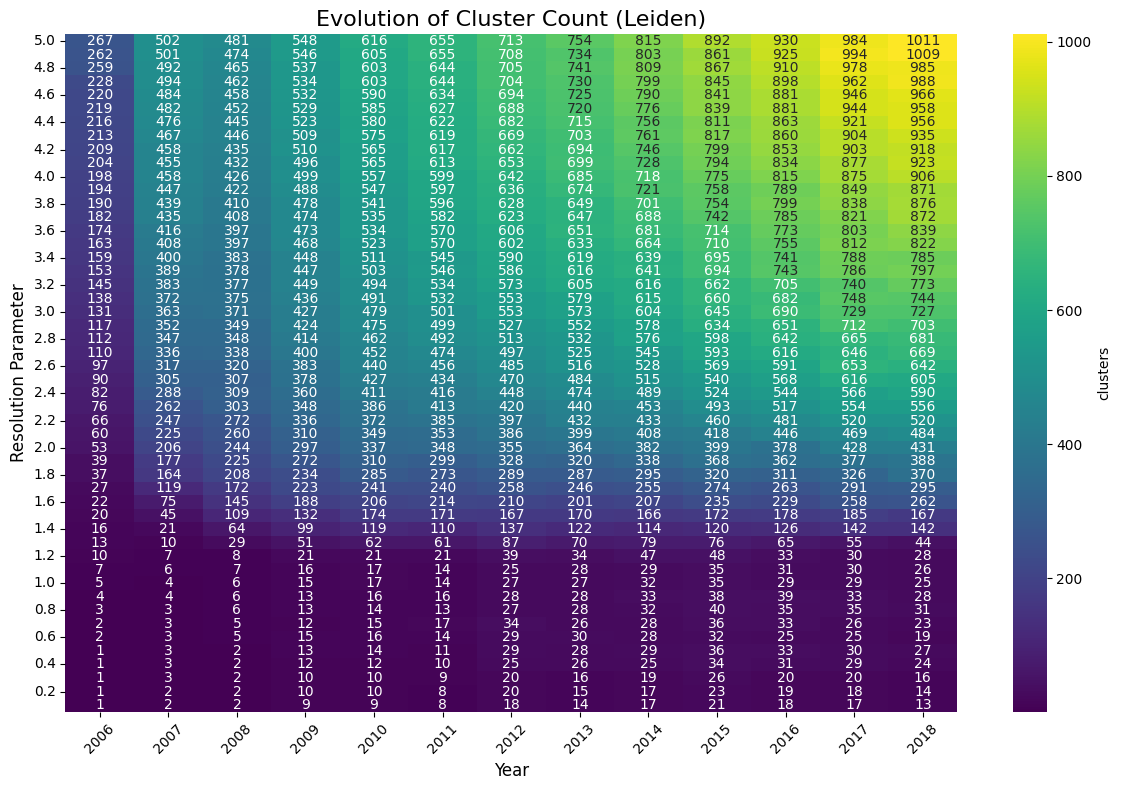

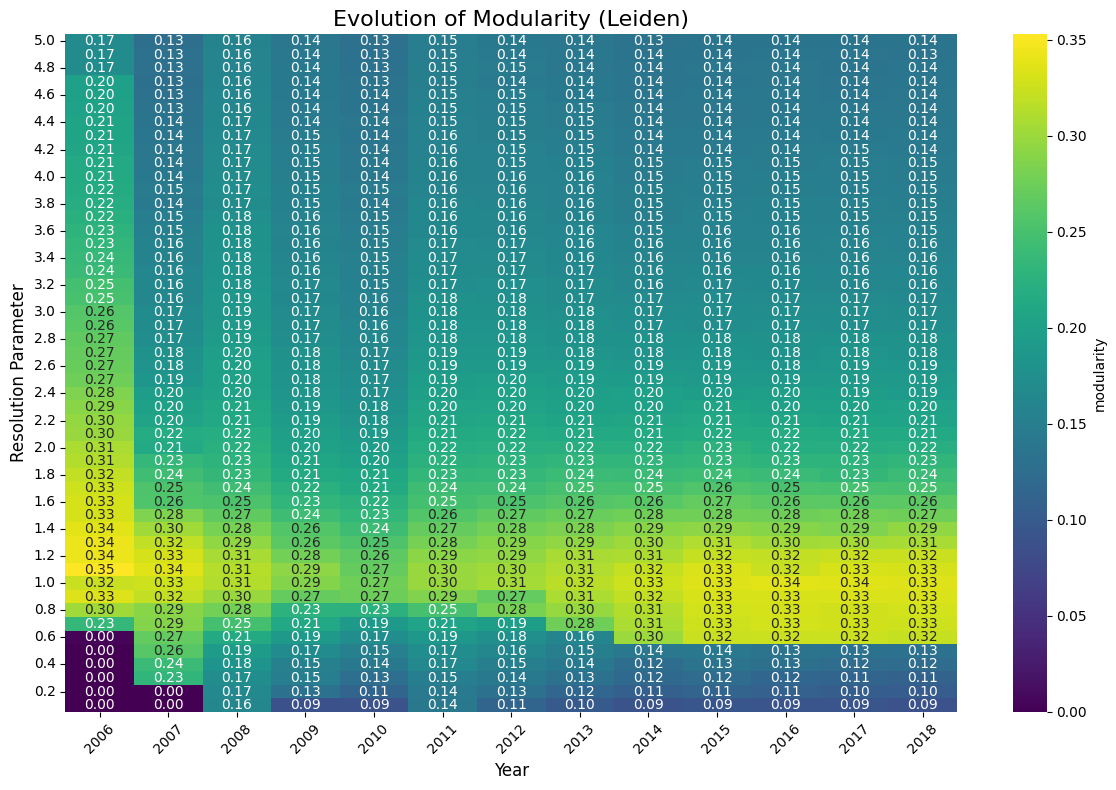

In [24]:
d = pd.read_csv('data/experiments/clusterization_heatmaps/leiden_mod.csv')
plot_resolution_heatmap(df_sorted, metric_col='clusters', title="Evolution of Cluster Count (Leiden)")
plot_resolution_heatmap(df_sorted, metric_col='modularity', title="Evolution of Modularity (Leiden)")